
Created by Kaan Cökerim on 31.07.2024
Email: kaan.coekerim@rub.de
Description: script to evaluate the test data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py
import datetime
import xarray as xr

### Set path to hdf-file containing the data

In [2]:
# hdf path
hdf_paths = './data/tables'

### Select Station and load data

In [22]:
station_name = 'POVE'  # MCHL

In [23]:
with h5py.File(os.path.join(hdf_paths, f'{station_name}_0_dataset.hdf5'), 'r') as fin:
    time = np.array(fin.get('base/time'))
    gnss = np.array(fin.get('base/gnss'))
    hydl = np.array(fin.get('base/hydl'))
    ntol = np.array(fin.get('base/ntol'))
    ntal = np.array(fin.get('base/ntal'))

    models = fin.get('models')
    model_dict = {'prediction': np.array(models.get(f'Non-Tect/prediction')),
                  'target': np.array(models.get(f'Non-Tect/target')),
                  'time': list(map(datetime.date.fromordinal, np.array(models.get(f'Non-Tect/time'))))
                  }

hydl -= np.nanmedian(hydl)
ntol -= np.nanmedian(ntol)
ntal -= np.nanmedian(ntal)
gnss -= np.nanmedian(gnss)

ntl = hydl + ntal + ntol

time = list(map(datetime.date.fromordinal, time))

with np.load(f'./data/OS_LISFLOOD/{station_name}_lisflood.npz', allow_pickle=True) as lisflood_in:
    lisflood = lisflood_in['data']
    time_lisflood = lisflood_in['time']
    
assert time_lisflood[0] == time[0]

ntlis = lisflood + ntal[:lisflood.size] + ntol[:lisflood.size]

### Time Series Plot for NGL target

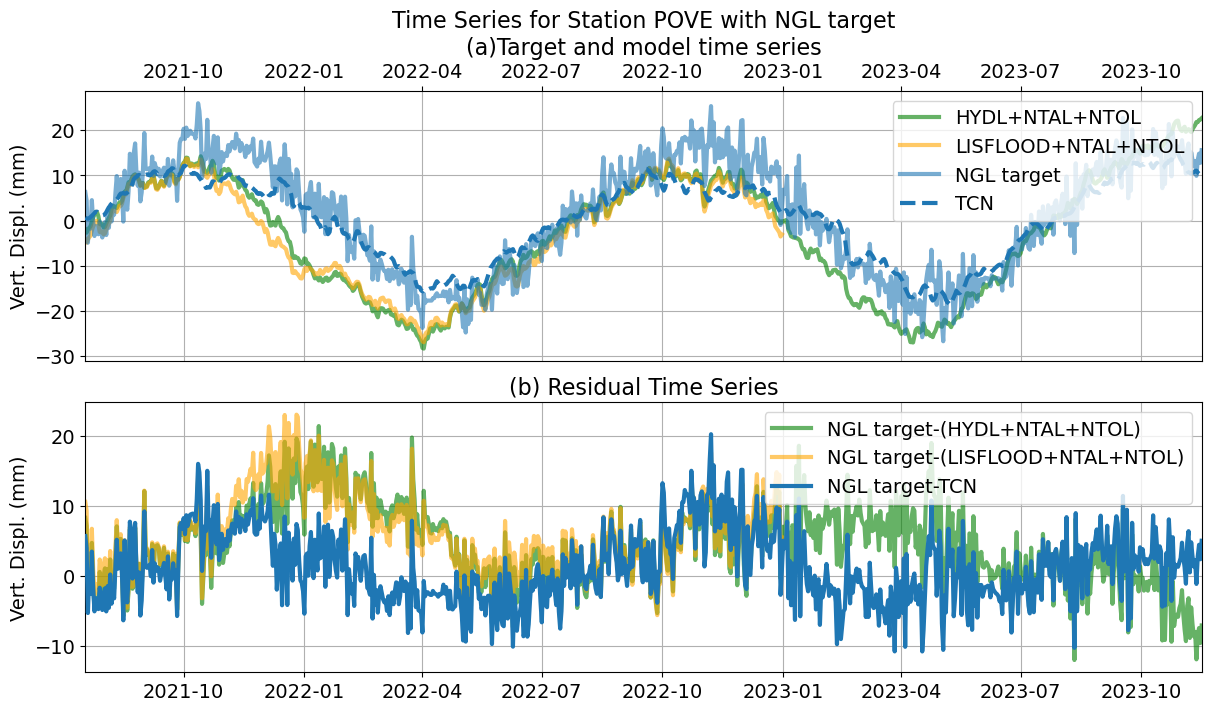

In [24]:
fig, ax = plt.subplots(figsize=(12, 7), nrows=2, ncols=1, constrained_layout=True)

ax[0].plot(model_dict['time'], ntl, color=f'green', alpha=0.6, lw=3, label=f'HYDL+NTAL+NTOL')
ax[0].plot(time[:lisflood.size], ntlis, color=f'orange', alpha=0.6, lw=3, label=f'LISFLOOD+NTAL+NTOL')
ax[0].plot(model_dict['time'], model_dict['target'], lw=3, color=f'C0', alpha=0.6, label=f'NGL target')
ax[0].plot(model_dict['time'], model_dict['prediction'], '--', lw=3, label=f'TCN', color=f'C0', zorder=100)

ax[0].set_ylabel('Vert. Displ. (mm)', fontsize=14)
ax[0].set_title(f'Time Series for Station {station_name} with NGL target'
                f'\n(a)Target and model time series', fontsize=16)
lg = ax[0].legend(fontsize=14, loc='upper right')
lg.set_zorder(200)
ax[0].set_xlim([model_dict['time'][0], model_dict['time'][-1]])
ax[0].xaxis.set_label_position("top")
ax[0].xaxis.tick_top()
ax[0].tick_params(axis='both', labelsize=14)
ax[0].grid(True)

# -------------
ax[1].set_title(f'(b) Residual Time Series', fontsize=16)
ax[1].plot(model_dict['time'], model_dict['target'] - ntl,
           color=f'green', alpha=0.6, lw=3, label=f'NGL target-(HYDL+NTAL+NTOL)')
ax[1].plot(time[:lisflood.size], model_dict['target'][:lisflood.size] - ntlis,
           color=f'orange', alpha=0.6, lw=3, label=f'NGL target-(LISFLOOD+NTAL+NTOL)')
ax[1].plot(model_dict['time'], model_dict['target'] - model_dict['prediction'],
           '-', lw=3, label=f'NGL target-TCN', color=f'C0', zorder=100)

ax[1].set_ylabel('Vert. Displ. (mm)', fontsize=14)
lgd = ax[1].legend(fontsize=14, loc='upper right')
lgd.set_zorder(102)
ax[1].set_xlim([model_dict['time'][0], model_dict['time'][-1]])
ax[1].tick_params(axis='both', labelsize=14)
ax[1].grid(True)

plt.show()
